* Test Set : 2015 Aug to 2015 17 Sep (6 weeks)
* Train Set from 2013 to 2015 Jul

* Visualization
https://www.kaggle.com/omarelgabry/rossmann-store-sales/a-journey-through-rossmann-stores<br>
http://nbviewer.jupyter.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb<br>

* Output Submissions File

* Other Solutions
<br> http://mabrek.github.io/blog/kaggle-forecasting
<br>https://github.com/mabrek/kaggle-rossman-store-sales
<br> http://nbviewer.jupyter.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb

* tbats : http://robjhyndman.com/hyndsight/dailydata/
* Try ARIMA

* Output to CSV => Run R XGBOOST

* For selecting a hold out set, I always try to imitate the way that the train and test set were split. So, if it is a time split, I split my holdout sample time based; if it is a geographical split by city, I split my holdout set by city; and if it is a random split, then my holdout split will be random as well. 

*  calculation of averages over different time windows. For each day in the sales history, I calculated averages over the last quarter, last half year, last year and last 2 years. Those averages were split out by important features like day of week and promotions. Second, some time indicators were important: not only month and day of year, but also relative indicators like number of days since the summer holidays started. Like most teams, I used extreme gradient boosting (xgboost) as a learning method.

* Remove dates where store is closed? Look at test data

* Join table. Indicate promo2 on data

* Add week of year.. for Christmas holidays eg

* Break down year and month for analysis

* Box plot for week of year, day of week..

* Recent Data -- Extract Features on last quarter, last 0.5 year, 1 year and 2 years , Median / Mean / Harmonic Mean , SD / Skewness / Kurtosis

* Temporal Information - day counter indicates either the number of days before, after or within the event (promotion cycle 14 days, secondary promotion every 3 months , summer holidays, store refurbishments, start of competition, start of secondary promotion cycle) 

* Harmonic Mean (Less affected by outliers)

* https://www.kaggle.com/c/rossmann-store-sales/forums/t/18024/model-documentation-1st-place

1. Feature engineering: Regular features +

-- week of the year
-- quarter of the year
-- week start date (day)
-- week end date (day)
-- week of month
-- refurbishment flag
-- days before refurbishment - the idea was there must be some type of announcement before refurbishments before the stores in BY went close for a period of time which in turn could have affected the regular trend.
-- days since refurb
-- Median sales at store-dayOfWeek level
-- receipt - ratio of total sales for a store in the store-state-storetype-assortment cluster
-- a variable combining different storetypes and assortments
-- historical quadratic trend for each stores
-- special day flag - improvisation on state holiday with extended holidays - like Assumption of Mary and May day have different effect on sales.
-- Is previous holiday
-- Is next holiday
-- total school holidays in a week/month
-- is schoolholiday in a adjacent state
-- Sales per customer at store level
-- Sales per customer at store - day of week level
-- Ratio of sales for each week day with and without promo (after outlier clean up)
-- median customer at store level
-- median customer at store & day of week level
-- SaturdayRatio for weeks with and without promo ( for a few stores saturday sales were higher than Mondays when there were no promo)
-- SundayRatio as above
-- PromoInterval window - coded 1, 2, 3 for each month in the promo2 cycle and same for days
-- marking stores for which a competition entered within the course of the given time frame
-- Flag for weeks before, on and after X-mas, new years eve
-- holidayfactor, a factor indicating the effect of holiday on nearby period
-- competition factor
-- kmeans cluster of stores based on sale
-- days to next open
-- daily variation of sales with and without promo at day of week- store level
-- daily variation of sales with and without promo at month- store level
-- a few other relevant stuff
external features:
-- state
-- weather (maxtemp, mintemp, maxprec, rain, snow etc.)
-- google trends

In [63]:
# %store dfm
%store dfxgb
# %store store_test_train_diff
# %store store_missing_data


# %store -r dfm
# %store -r dfxgb
# %store -r store_test_train_diff
# %store -r store_missing_data


# f = open('rossmann.pickle', 'wb')  
# save = {
#     'dfm': dfm
#     }
# pickle.dump(save,f)
# f.close()

# with open('rossmann.pickle','rb') as f:
#   save = pickle.load(f)
#   dfm = save['dfm']

  

Stored 'dfxgb' (DataFrame)


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import gc
from datetime import datetime
import time
import pickle
from IPython.core.display import display,HTML
import pickle

from scipy.optimize import (minimize,basinhopping)
from scipy.stats import uniform as sp_rand
import scipy.stats as spy

from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import (GradientBoostingClassifier,RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split

import seaborn as sb
import matplotlib.pyplot as plt  
%matplotlib inline

In [3]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1/(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

# def rmspe_xg(yhat, y):
#     # y = y.values
#     y = y.get_label()
#     y = np.exp(y) - 1
#     yhat = np.exp(yhat) - 1
#     w = ToWeight(y)
#     rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
#     return "rmspe", rmspe

In [3]:
# Testing how it works
y = np.array([0,0,1,1,2,0,1])
ToWeight(y)

array([ 0.  ,  0.  ,  1.  ,  1.  ,  0.25,  0.  ,  1.  ])

In [21]:
dstore = pd.read_csv('store.csv',dtype={'Store':int})
dtrain = pd.read_csv('train.csv',
                     parse_dates=['Date'],
                     date_parser=(lambda dt:pd.to_datetime(dt,format='%Y-%m-%d')),
                     dtype={'Store':np.int16,'DayOfWeek':np.int8,'Sales':int,'Customers':np.int16,'Open':np.int8,'Promo':np.int8,'SchoolHoliday':np.int8})
holiday_columns = ['0','a','b','c']
dtrain['StateHoliday'] = pd.Categorical(dtrain.StateHoliday, categories=holiday_columns)
# dtrain.info()
dtest = pd.read_csv('test.csv',
                    dtype={'Id':int,'Store':np.int16,'DayOfWeek':np.int8,'Promo':np.int8,'SchoolHoliday':np.int8},
                    parse_dates=['Date'],
                    date_parser=(lambda dt:pd.to_datetime(dt,format='%Y-%m-%d')))
dtest['Open'].fillna(0,inplace=True)
dtest['Open'] = dtest['Open'].astype(int)
# dtest = pd.read_csv('test.csv')
dtest['StateHoliday'] = pd.Categorical(dtest.StateHoliday, categories=holiday_columns)


C:\Users\Chen Jenn Haur\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dtrain.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
# Data Exploration 

print("Start Date %s and End Date %s in train dataset" % (dtrain['Date'].min().strftime('%Y-%m-%d'),dtrain['Date'].max().strftime('%Y-%m-%d')))
print("Start Date %s and End Date %s in test dataset" % (dtest['Date'].min().strftime('%Y-%m-%d'),dtest['Date'].max().strftime('%Y-%m-%d')))

Start Date 2013-01-01 and End Date 2015-07-31 in train dataset
Start Date 2015-08-01 and End Date 2015-09-17 in test dataset


In [22]:
# Check that test set and train set distribution is equal. Both contains all store data
# print(set(dtest['Store']) - set(dtrain['Store']))
# print(set(dtrain['Store']) - set(dtest['Store']))
store_train_list = set(dtrain['Store'])
store_test_list = set(dtest['Store'])
store_test_train_diff = (list(store_test_list.symmetric_difference(store_train_list)))
print("No of stores in trainset %d. No of stores in test set %d"%(len(store_train_list),len(store_test_list)))
print(store_test_train_diff)
# pd.pivot_table(dtrain,index=['Store'],values=["Date"],aggfunc=[max,min])

No of stores in trainset 1115. No of stores in test set 856
[2, 4, 5, 6, 17, 18, 26, 28, 34, 37, 44, 54, 55, 57, 59, 60, 65, 78, 85, 87, 88, 95, 96, 97, 103, 104, 106, 114, 116, 121, 123, 125, 133, 134, 138, 148, 151, 156, 163, 167, 173, 177, 178, 185, 196, 198, 203, 205, 208, 211, 222, 223, 225, 232, 236, 237, 240, 257, 260, 261, 264, 266, 270, 271, 276, 282, 286, 291, 292, 293, 307, 313, 318, 321, 322, 324, 327, 332, 349, 357, 360, 361, 363, 366, 374, 375, 376, 381, 382, 384, 390, 396, 400, 401, 402, 419, 423, 436, 437, 438, 439, 443, 444, 454, 460, 462, 464, 469, 474, 476, 478, 479, 480, 482, 483, 489, 494, 496, 503, 513, 523, 525, 526, 544, 546, 556, 559, 560, 569, 576, 583, 594, 595, 596, 599, 606, 607, 608, 609, 613, 614, 617, 626, 630, 634, 635, 648, 649, 652, 654, 664, 668, 672, 679, 682, 683, 686, 688, 698, 704, 708, 709, 715, 726, 730, 735, 743, 745, 747, 754, 755, 760, 761, 779, 780, 781, 783, 786, 787, 788, 794, 798, 808, 812, 814, 817, 821, 827, 828, 830, 834, 836, 838, 83

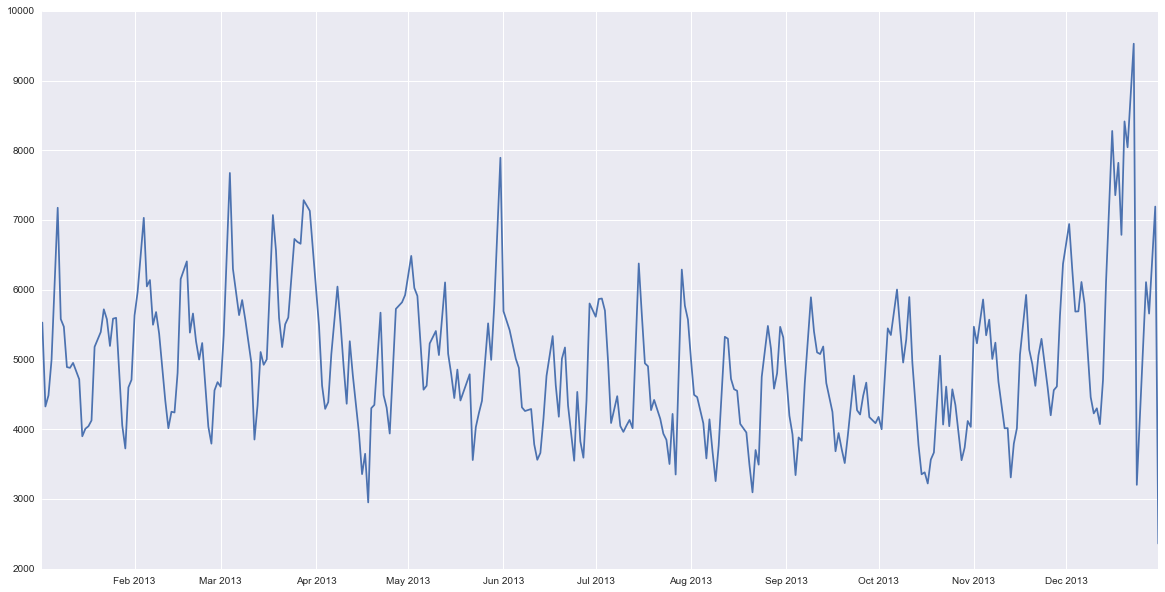

In [8]:
# criteria = dtrain[(dtrain['Store']==1) & (dtrain['Date']<datetime.date(2014,1,1))]
criteria = dtrain[(dtrain['Store']==1) & (dtrain['Sales']>0) & (dtrain['Date']<datetime.date(2014,1,1))].copy()
# criteria = dtrain[dtrain['Store']==1]
plt.figure(figsize=(20,10))
plt.plot(criteria['Date'].values,criteria['Sales'].values)
# d = criteria['Date']
# s = criteria['Sales']
# plt.plot(d,s)

In [40]:
dtrain = dtrain.set_index(dtrain['Date'])
dtest = dtest.set_index(dtest['Date'])

In [10]:
dtrain.index[0]
# dtrain.resample('W',how='sum')

Timestamp('2015-07-31 00:00:00')

In [11]:
dtrain.index.min()

Timestamp('2013-01-01 00:00:00')

In [12]:
dtrain.loc[pd.Timestamp('2013-01-01 00:00:00'):pd.Timestamp('2013-02-02 00:00:00')]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,,


In [23]:
dtrain['Set'] = 1
dtest['Set'] = 0
### Combine train and test set
frames = [dtrain, dtest]
df = pd.concat(frames)

In [24]:
#Enhance Features

var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day.astype(np.int8)
df[var_name + 'Week'] = pd.Index(df[var_name]).week.astype(np.int8)
df[var_name + 'Month'] = pd.Index(df[var_name]).month.astype(np.int8)
df[var_name + 'Year'] = pd.Index(df[var_name]).year.astype(np.int16)
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear.astype(np.int16)
df['DateInt'] = df['Date'].apply(lambda x: time.mktime(pd.to_datetime(x).timetuple())).astype(np.int32)
df['Set'] = df['Set'].astype(np.int8)
df['Open'] = df['Open'].astype(np.int8)
df['Promo'] = df['Promo'].astype(np.int8)
df['SchoolHoliday'] = df['SchoolHoliday'].astype(np.int8)
# df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 17 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int8
Id               41088 non-null float64
Open             1058297 non-null int8
Promo            1058297 non-null int8
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int8
Set              1058297 non-null int8
StateHoliday     927225 non-null category
Store            1058297 non-null int16
DateDay          1058297 non-null int8
DateWeek         1058297 non-null int8
DateMonth        1058297 non-null int8
DateYear         1058297 non-null int16
DateDayOfYear    1058297 non-null int16
DateInt          1058297 non-null int32
dtypes: category(1), datetime64[ns](1), float64(3), int16(3), int32(1), int8(8)
memory usage: 59.5 MB


In [25]:
for feature in dstore.columns:
    dstore[feature] = dstore[feature].fillna(0)

dstore['StoreType'] = dstore['StoreType'].astype('category').cat.codes
dstore['Assortment'] = dstore['Assortment'].astype('category').cat.codes
dstore['CompetitionDistance'] = dstore['CompetitionDistance'].astype(np.int32)
dstore['CompetitionOpenSinceYear'] = dstore['CompetitionOpenSinceYear'].astype(np.int16)
dstore['CompetitionOpenSinceMonth'] = dstore['CompetitionOpenSinceMonth'].astype(np.int8)
dstore['Promo2'] = dstore['Promo2'].astype(np.int8)
dstore['Promo2SinceWeek'] = dstore['Promo2SinceWeek'].astype(np.int8)
dstore['Promo2SinceYear'] = dstore['Promo2SinceYear'].astype(np.int16)
display(dstore.describe())
display(dstore.info())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,1.217040,0.928251,5390.358744,4.930942,1370.939013,0.512108,12.083408,1030.239462
std,322.01708,1.369544,0.993814,7657.973705,4.284924,935.467654,0.500078,15.542241,1006.038782
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.50000,0.000000,0.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.00000,0.000000,0.000000,2320.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000
75%,836.50000,3.000000,2.000000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.00000,3.000000,2.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int32
StoreType                    1115 non-null int8
Assortment                   1115 non-null int8
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int8
CompetitionOpenSinceYear     1115 non-null int16
Promo2                       1115 non-null int8
Promo2SinceWeek              1115 non-null int8
Promo2SinceYear              1115 non-null int16
PromoInterval                1115 non-null object
dtypes: int16(2), int32(2), int8(5), object(1)
memory usage: 27.3+ KB


None

In [8]:
# Time Manipulation
# dts = [datetime(1970,1,1),datetime(1971,1,1),datetime(2015,1,1)]
# ts = pd.Series(dts)
# y = (ts.astype(np.int64)/1000000000).astype(np.int)
# y

t = datetime(2016,1,1,14,31,30)
time.mktime(t.timetuple())

1451629890.0

In [26]:
### Convert competition open year and month to float
def convertCompetitionOpen(dsf):
    try:
        date = '{}-{}'.format(int(dsf['CompetitionOpenSinceYear']), int(dsf['CompetitionOpenSinceMonth']))
        return time.mktime(pd.to_datetime(date).timetuple())
    except:
        #return datetime.date(1970,1,1)
        return 0 

dstore['CompetitionOpenInt'] = dstore.apply(lambda dsf: convertCompetitionOpen(dsf), axis=1).astype(np.int32)

In [27]:
### Convert competition open year and month to float
def convertPromo2(dsf):
    try:
        # %w = 1 refers to Monday
        date = '{}{}1'.format(int(dsf['Promo2SinceYear']), int(dsf['Promo2SinceWeek']))
#         return pd.to_datetime(date, format='%Y%W%w')
        return time.mktime(pd.to_datetime(date, format='%Y%W%w').timetuple())
    except:
#         return datetime.datetime(1970,1,1)
        return 0 

dstore['Promo2SinceFloat'] = dstore.apply(lambda dsf: convertPromo2(dsf), axis=1).astype(np.int32)

In [74]:
dstore.iloc[:,7:12].head(10)

,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2SinceFloat
0,0,0,0,1220198400,0
1,13,2010,"Jan,Apr,Jul,Oct",1193846400,1269792000
2,14,2011,"Jan,Apr,Jul,Oct",1164902400,1301846400
3,0,0,0,1251734400,0
4,0,0,0,1427817600,0
5,0,0,0,1385827200,0
6,0,0,0,1364745600,0
7,0,0,0,1412092800,0
8,0,0,0,965059200,0
9,0,0,0,1251734400,0


In [28]:
s = dstore['PromoInterval'].str.split(',').apply(pd.Series)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
dstore = dstore.join(s)

In [29]:
monthToNum = {
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    } 
# def monthToNum(date):
#     return{
#             'Jan' : 1,
#             'Feb' : 2,
#             'Mar' : 3,
#             'Apr' : 4,
#             'May' : 5,
#             'Jun' : 6,
#             'Jul' : 7,
#             'Aug' : 8,
#             'Sept' : 9, 
#             'Oct' : 10,
#             'Nov' : 11,
#             'Dec' : 12
#     }[date]
# monthToNum('Jan')['Jan']

dstore['PromoInterval0'] = dstore['PromoInterval0'].apply(lambda x: monthToNum[x] if str(x) != 'nan' else 0).astype(np.int8)
dstore['PromoInterval1'] = dstore['PromoInterval1'].apply(lambda x: monthToNum[x] if str(x) != 'nan' else 0).astype(np.int8)
dstore['PromoInterval2'] = dstore['PromoInterval2'].apply(lambda x: monthToNum[x] if str(x) != 'nan' else 0).astype(np.int8)
dstore['PromoInterval3'] = dstore['PromoInterval3'].apply(lambda x: monthToNum[x] if str(x) != 'nan' else 0).astype(np.int8)
# dstore.head(5)

In [77]:
dstore.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2SinceFloat,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,1,c,a,1270,9,2008,0,0,0,0,1220198400,0,0,0,0,0
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",1193846400,1269792000,1,4,7,10
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1164902400,1301846400,1,4,7,10
3,4,c,c,620,9,2009,0,0,0,0,1251734400,0,0,0,0,0
4,5,a,a,29910,4,2015,0,0,0,0,1427817600,0,0,0,0,0


In [30]:
dfm = pd.merge(df,dstore,how='left',on=['Store'])

In [31]:
for feature in dfm.columns:
    dfm[feature] = dfm[feature].fillna(0)
dfm.head(5)

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2SinceFloat,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,555.0,2015-07-31,5,0.0,1,1,5263.0,1,1,0,...,0,0,0,0,1220198400,0,0,0,0,0
1,625.0,2015-07-31,5,0.0,1,1,6064.0,1,1,0,...,1,13,2010,"Jan,Apr,Jul,Oct",1193846400,1269792000,1,4,7,10
2,821.0,2015-07-31,5,0.0,1,1,8314.0,1,1,0,...,1,14,2011,"Jan,Apr,Jul,Oct",1164902400,1301846400,1,4,7,10
3,1498.0,2015-07-31,5,0.0,1,1,13995.0,1,1,0,...,0,0,0,0,1251734400,0,0,0,0,0
4,559.0,2015-07-31,5,0.0,1,1,4822.0,1,1,0,...,0,0,0,0,1427817600,0,0,0,0,0


In [32]:
del dtrain
del dtest
del df
del dstore
gc.collect()

dfm.drop("Promo2",axis=1,inplace=True)
dfm.drop("PromoInterval",axis=1,inplace=True)
dfm['Sales'] = dfm['Sales'].astype(np.float32)
# c = pd.Timedelta('8 hours')
# dfm['DateTime']  = pd.to_datetime(dfm['Date'] + c)
dfm = dfm.set_index(pd.DatetimeIndex(dfm['Date']))
dfm['Customers'] = dfm['Customers'].astype(np.int16)
dfm['Id'] = dfm['Id'].astype(np.uint16)

display(dfm.describe())
display(dfm.info())

,Customers,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,Store,DateDay,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,CompetitionOpenInt,Promo2SinceFloat,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
count,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,...,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06,1.058297e+06
mean,6.085643e+02,3.997596e+00,7.976328e+02,8.310380e-01,3.820704e-01,5.549568e+03,1.889290e-01,9.611754e-01,5.583315e+02,1.561808e+01,...,4.907584e+00,1.366081e+03,1.174607e+01,1.013264e+03,8.433026e+08,6.706343e+08,8.135693e-01,2.324584e+00,3.835598e+00,5.346613e+00
std,4.714490e+02,1.998099e+00,4.605738e+03,3.747185e-01,4.858939e-01,3.929688e+03,3.914524e-01,1.931769e-01,3.218456e+02,8.784827e+00,...,4.281957e+00,9.369522e+02,1.536577e+01,1.005852e+03,5.920233e+08,6.667190e+08,9.817884e-01,2.374148e+00,3.848247e+00,5.336778e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.630000e+02,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.319000e+03,0.000000e+00,1.000000e+00,2.800000e+02,8.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.940000e+02,4.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,5.600000e+03,0.000000e+00,1.000000e+00,5.580000e+02,1.600000e+01,...,4.000000e+00,2.006000e+03,1.000000e+00,2.009000e+03,1.157040e+09,1.249229e+09,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01
75%,8.240000e+02,6.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,7.749000e+03,0.000000e+00,1.000000e+00,8.370000e+02,2.300000e+01,...,9.000000e+00,2.011000e+03,2.200000e+01,2.012000e+03,1.320077e+09,1.333296e+09,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01
max,7.388000e+03,7.000000e+00,4.108800e+04,1.000000e+00,1.000000e+00,4.155100e+04,1.000000e+00,1.000000e+00,1.115000e+03,3.100000e+01,...,1.200000e+01,2.015000e+03,5.000000e+01,2.015000e+03,1.438358e+09,1.433693e+09,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1058297 entries, 2015-07-31 to 2015-08-01
Data columns (total 30 columns):
Customers                    1058297 non-null int16
Date                         1058297 non-null datetime64[ns]
DayOfWeek                    1058297 non-null int8
Id                           1058297 non-null uint16
Open                         1058297 non-null int8
Promo                        1058297 non-null int8
Sales                        1058297 non-null float32
SchoolHoliday                1058297 non-null int8
Set                          1058297 non-null int8
StateHoliday                 1058297 non-null object
Store                        1058297 non-null int16
DateDay                      1058297 non-null int8
DateWeek                     1058297 non-null int8
DateMonth                    1058297 non-null int8
DateYear                     1058297 non-null int16
DateDayOfYear                1058297 non-null int16
DateInt                      105829

None

In [18]:
print("Test Set Days", dfm[dfm['Set']==0]['Date'].max() - dfm[dfm['Set']==0]['Date'].min())
print("Train Set Days", dfm[dfm['Set']==1]['Date'].max() - dfm[dfm['Set']==1]['Date'].min())

Test Set Days 47 days 00:00:00
Train Set Days 941 days 00:00:00


In [33]:
a = dfm.groupby(['Store','Set'])['DayOfWeek'].count()
type(a)
a.index
# store_miss = np.asarray(np.where((a.loc[:,1] < 900) & (a.loc[:,1] > 900) )) + 1
store_missing_data = np.asarray(np.where(a.loc[:,1] < 900)) + 1
print("Training Data where data is not complete ",store_missing_data.size)

display(store_missing_data)

print("Test Data where data is not complete")
display(np.where(a.loc[:,0] < 48))

# a.loc[[1,2,3,7],0]
# a.loc[list(store_missing_data[0]),1]

Training Data where data is not complete  180


array([[  13,   20,   22,   32,   36,   41,   46,   51,   52,   58,   72,
          76,   81,   89,   99,  100,  108,  113,  115,  127,  129,  132,
         136,  137,  139,  144,  145,  149,  155,  159,  164,  165,  172,
         174,  181,  183,  186,  190,  191,  192,  204,  215,  218,  231,
         243,  258,  263,  275,  277,  279,  283,  284,  287,  288,  298,
         306,  317,  342,  345,  348,  365,  385,  399,  407,  412,  413,
         420,  427,  428,  429,  430,  434,  457,  471,  477,  485,  490,
         492,  498,  500,  501,  512,  514,  518,  522,  534,  539,  540,
         542,  547,  555,  571,  573,  575,  587,  598,  604,  611,  612,
         619,  620,  629,  633,  636,  637,  638,  644,  646,  650,  660,
         669,  670,  671,  677,  684,  694,  701,  702,  706,  710,  711,
         712,  716,  719,  736,  739,  744,  750,  766,  771,  775,  778,
         797,  804,  805,  806,  815,  820,  825,  842,  851,  858,  859,
         879,  884,  890,  893,  900, 

Test Data where data is not complete


(array([], dtype=int64),)

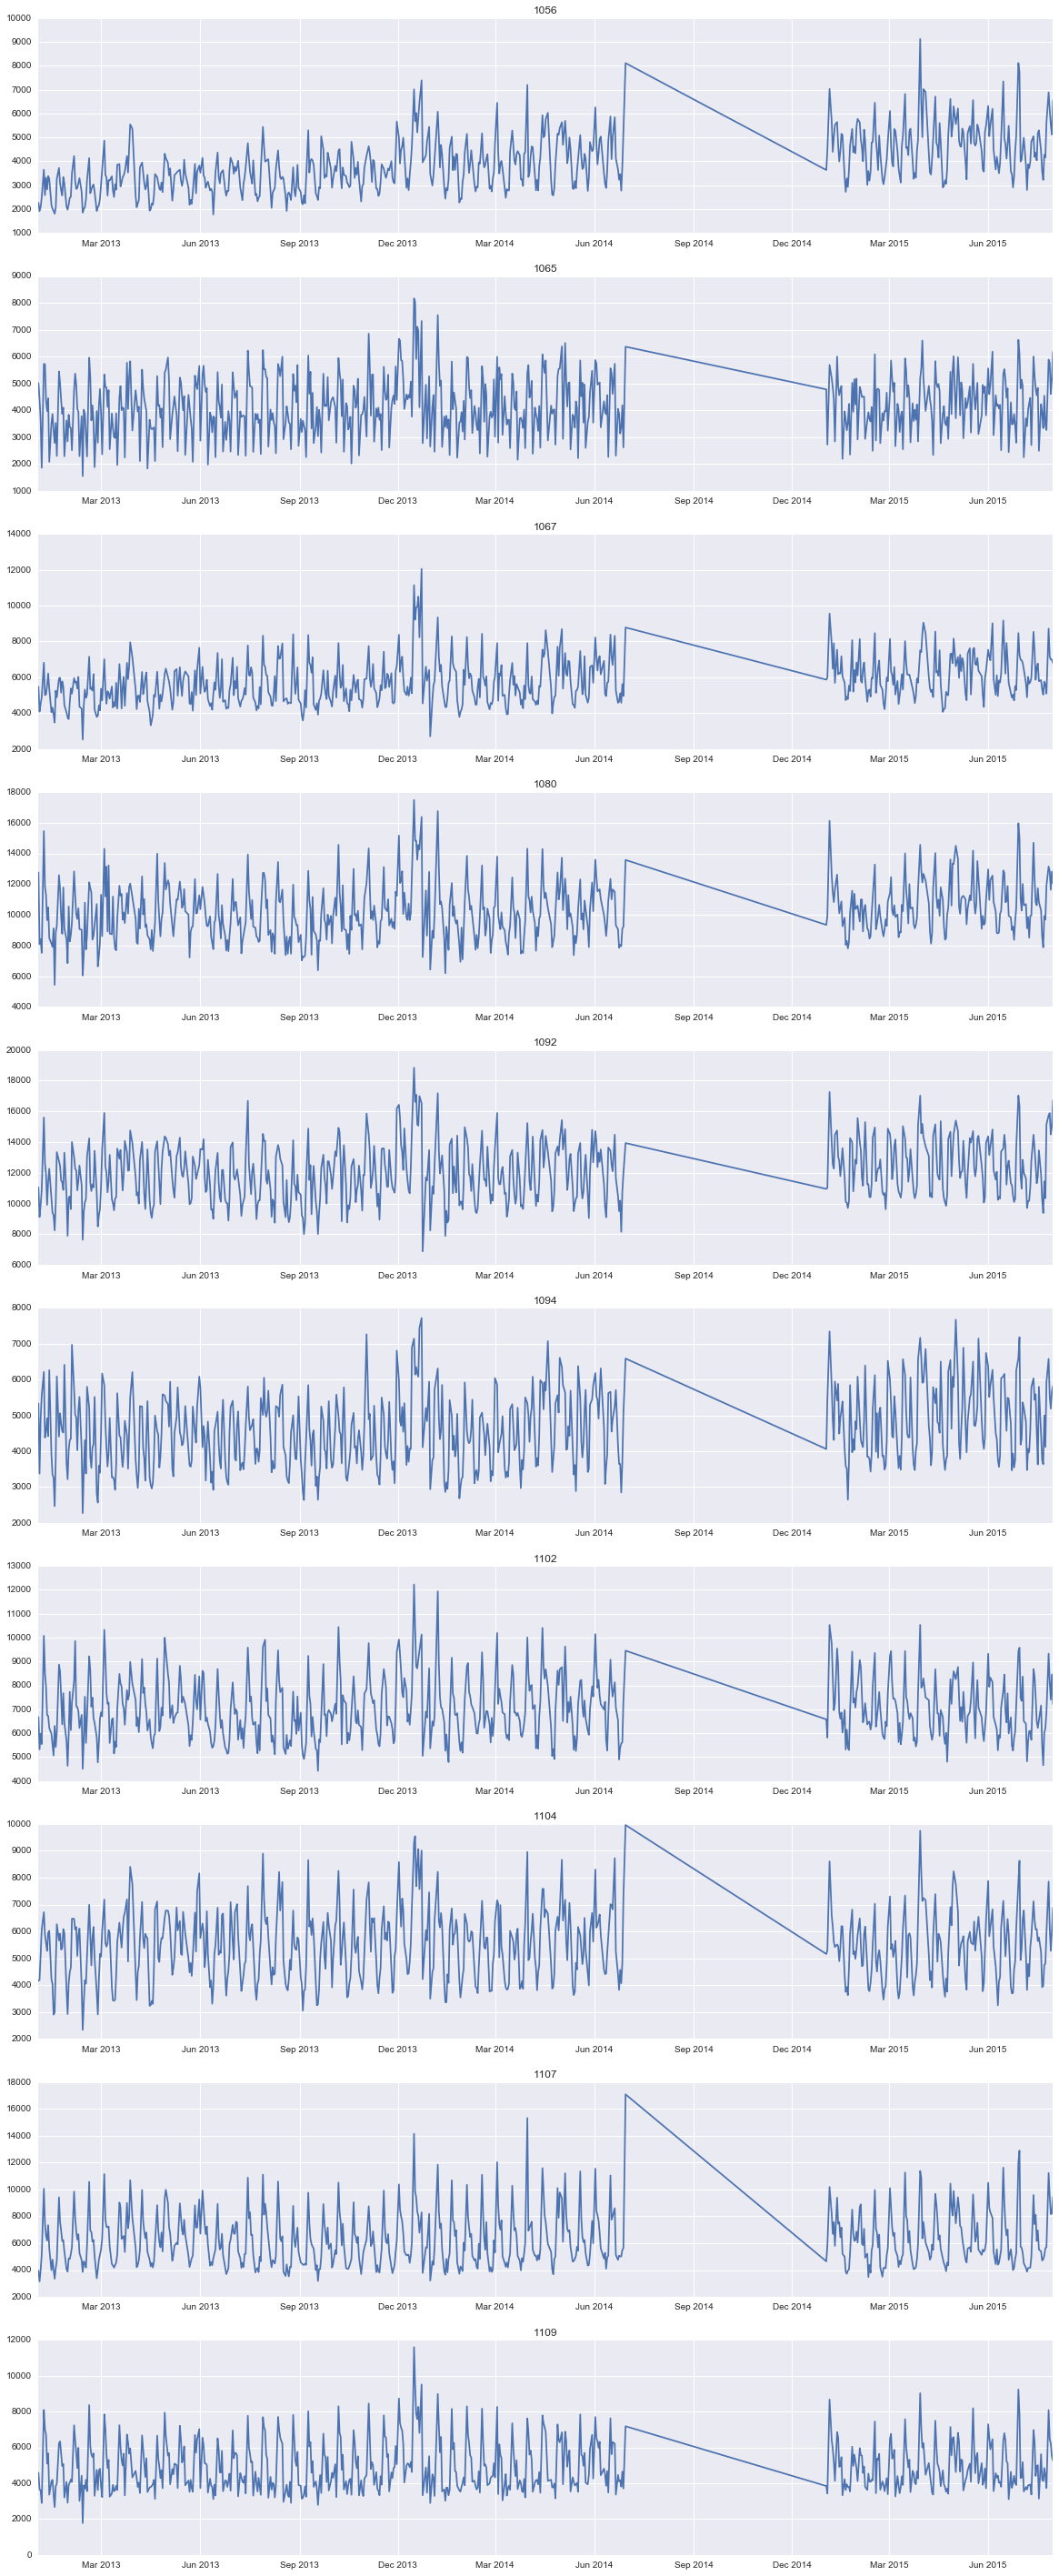

In [111]:
list_stores_to_check = list(store_missing_data[0])[170:181]
#Indices 1: - July to Dec 2014

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = dfm.loc[(dfm['Set'] == 1) & (dfm['Store'] == stor) & (dfm['Open'] == 1)]['Date'].values
    y1 = dfm.loc[(dfm['Set'] == 1) & (dfm['Store'] == stor) & (dfm['Open'] == 1)]['Sales'].values

    # subplot(len,ncol,nrow)
    plt.subplot(len(list_stores_to_check),1,j)
    # Draw - , Draw .
    plt.plot(X1, y1,'-')
#     plt.minorticks_on()
    plt.title(i)
    j += 1

In [122]:
dfm[dfm['Store'] == 13].groupby(['DateYear','DateMonth']).count()['Date']

DateYear  DateMonth
2013      1            31
          2            28
          3            31
          4            30
          5            31
          6            30
          7            31
          8            31
          9            30
          10           31
          11           30
          12           31
2014      1            31
          2            28
          3            31
          4            30
          5            31
          6            30
2015      1            31
          2            28
          3            31
          4            30
          5            31
          6            30
          7            31
          8            31
          9            17
Name: Date, dtype: int64

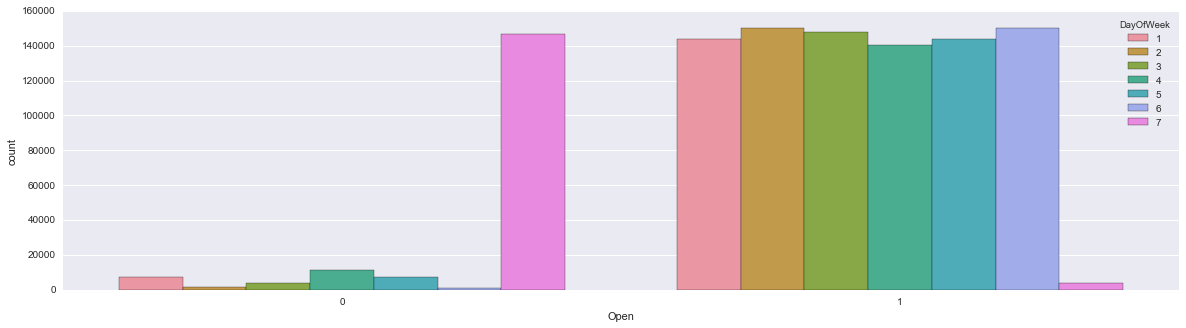

In [40]:
# fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
plt.rcParams["figure.figsize"] = [20,5]
sb.countplot(x='Open',hue='DayOfWeek', data=dfm)

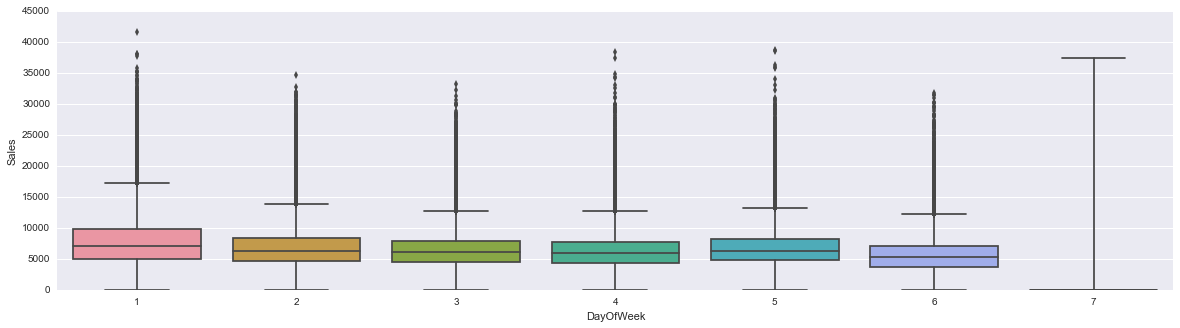

In [42]:
sb.boxplot(x='DayOfWeek',y='Sales',data=dfm)

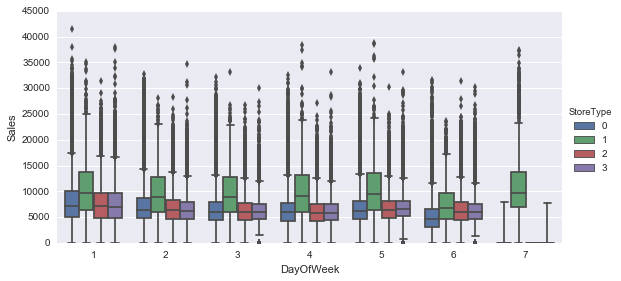

In [9]:
sb.factorplot(x="DayOfWeek", y="Sales", hue="StoreType", data=dfm, kind='box',size=4,aspect=2)

In [80]:
display(dfm.iloc[1:4,1:14])
display(dfm.iloc[1:4,14:20])
display(dfm.iloc[1:4,20:26])

,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,Store,DateDay,DateWeek,DateMonth,DateYear,DateDayOfYear,DateInt
2015-07-31,1,1,6064.0,1,1,0,2,31,31,7,2015,212,1438272000
2015-07-31,1,1,8314.0,1,1,0,3,31,31,7,2015,212,1438272000
2015-07-31,1,1,13995.0,1,1,0,4,31,31,7,2015,212,1438272000


,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek
2015-07-31,0,0,570,11,2007,13
2015-07-31,0,0,14130,12,2006,14
2015-07-31,2,2,620,9,2009,0


,Promo2SinceYear,CompetitionOpenInt,Promo2SinceFloat,PromoInterval0,PromoInterval1,PromoInterval2
2015-07-31,2010,1193846400,1269792000,1,4,7
2015-07-31,2011,1164902400,1301846400,1,4,7
2015-07-31,0,1251734400,0,0,0,0


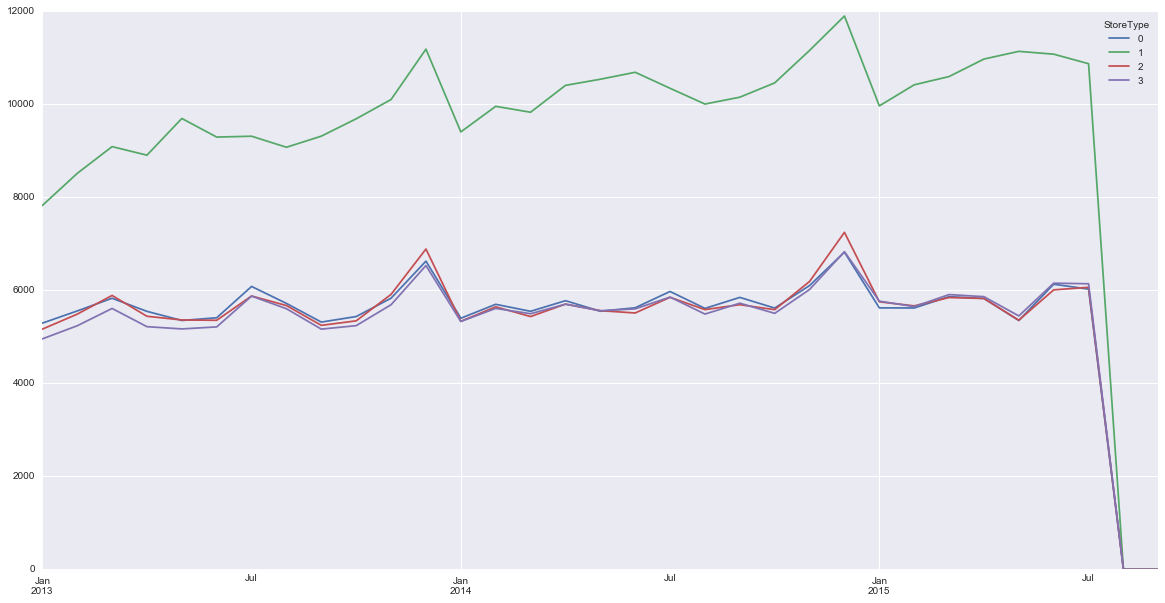

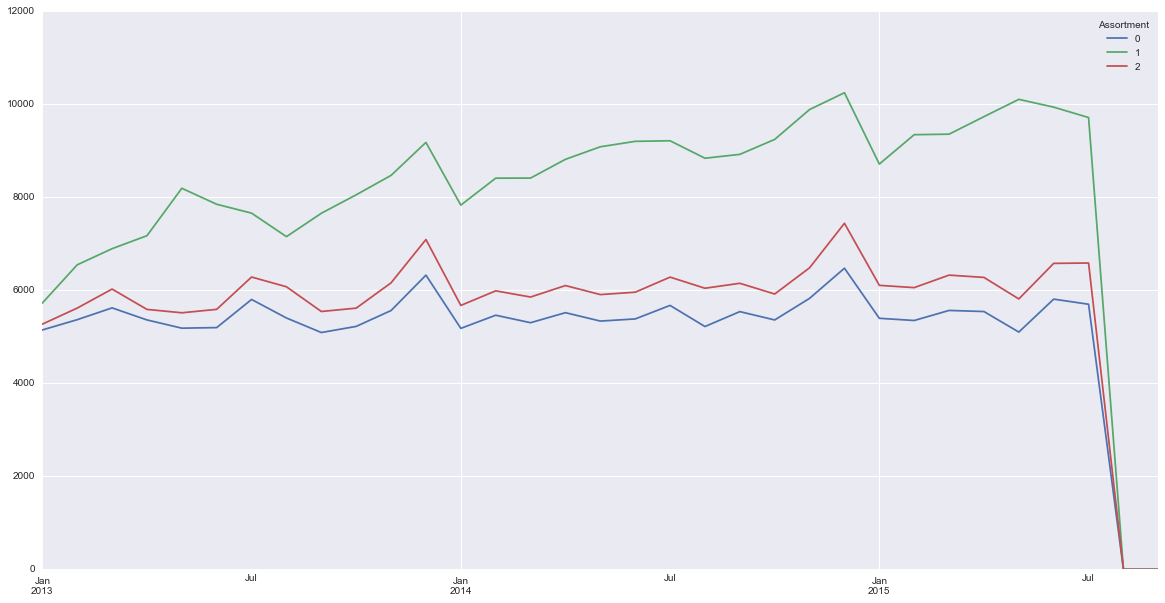

In [91]:
# dfm.index.is_unique
# dfm['Sales'].resample('M',kind='period').mean().plot()
# dfm.groupby(['StoreType']).resample('Q').mean()['Sales'].unstack(level=0).plot(subplots=True,figsize=(20,10))
# dfm.groupby(dfm.index.map(lambda t:t.quarter)).mean()['Sales']
dfm.groupby(['StoreType']).resample('M').mean()['Sales'].unstack(level=0).plot(figsize=(20,10))
dfm.groupby(['Assortment']).resample('M').mean()['Sales'].unstack(level=0).plot(figsize=(20,10))

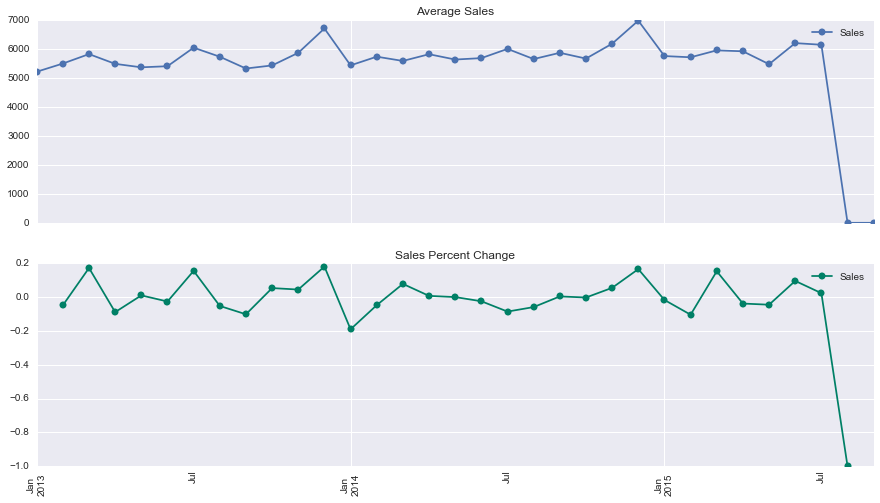

In [107]:
# group by date and get average sales, and precent change
average_sales    = dfm.resample('M').mean()['Sales']
pct_change_sales = dfm.resample('M').sum().pct_change()['Sales']

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
# ax1.set_xticks(range(len(average_sales)))
# ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")
# ax2.set_xticks(range(len(pct_change_sales)))
# ax2.set_xticklabels(pct_change_sales.index.tolist(), rotation=90)

In [104]:
display(dfm.resample('M').sum()['Sales'][0:5])
print('Percentage Change')
display(dfm.resample('M').sum().pct_change()['Sales'][0:5])
print(180132208.0 - (0.047731*180132208.0))

2013-01-31    180132208.0
2013-02-28    171534272.0
2013-03-31    201180368.0
2013-04-30    183431424.0
2013-05-31    185411056.0
Freq: M, Name: Sales, dtype: float32

Percentage Change


2013-01-31         NaN
2013-02-28   -0.047731
2013-03-31    0.172829
2013-04-30   -0.088224
2013-05-31    0.010792
Freq: M, Name: Sales, dtype: float32

171534317.579952


In [120]:
print(average_sales[:], " ", len(average_sales))
two_m_lag = average_sales.shift(2,freq='M')
print(two_m_lag[:], " ", len(two_m_lag))

2013-01-31    5211.555664
2013-02-28    5494.371582
2013-03-31    5820.349121
2013-04-30    5483.750000
2013-05-31    5364.127441
2013-06-30    5402.163086
2013-07-31    6042.062500
2013-08-31    5729.574219
2013-09-30    5322.988281
2013-10-31    5429.258789
2013-11-30    5864.601562
2013-12-31    6703.618164
2014-01-31    5431.875977
2014-02-28    5731.091309
2014-03-31    5584.257324
2014-04-30    5815.993164
2014-05-31    5632.670410
2014-06-30    5681.526367
2014-07-31    5999.403320
2014-08-31    5649.421387
2014-09-30    5865.104004
2014-10-31    5665.564941
2014-11-30    6179.249512
2014-12-31    6973.282227
2015-01-31    5752.748047
2015-02-28    5710.296387
2015-03-31    5949.130371
2015-04-30    5916.857422
2015-05-31    5472.122070
2015-06-30    6199.204102
2015-07-31    6142.705566
2015-08-31       0.000000
2015-09-30       0.000000
Freq: M, Name: Sales, dtype: float32   33
2013-03-31    5211.555664
2013-04-30    5494.371582
2013-05-31    5820.349121
2013-06-30    5483.750

In [34]:
# Standard Deviation
std = dfm.groupby('Store').std()['Sales']
mean = dfm.groupby('Store').mean()['Sales']
median = dfm.groupby('Store').median()['Sales']
hmean = dfm[dfm['Sales']>0].groupby('Store').apply(lambda x: spy.hmean(x['Sales']))

In [50]:
display(mean[1:5])
display(hmean[1:5])
display(median[1:5])

Store
2    4122.991699
3    5462.890137
4    8021.769531
5    3867.110352
Name: Sales, dtype: float32

Store
2    4431.563643
3    6282.239294
4    9288.398666
5    3914.304362
dtype: float64

Store
2    4395.5
3    5713.5
4    9062.0
5    4180.0
Name: Sales, dtype: float32

In [35]:
pd_mean = pd.DataFrame(mean).reset_index()
pd_mean.columns = ['Store','Sales_Mean']
pd_median = pd.DataFrame(median).reset_index()
pd_median.columns = ['Store','Sales_Median']
pd_hmean = pd.DataFrame(hmean).reset_index()
pd_hmean.columns = ['Store','Sales_HMean']
pd_std = pd.DataFrame(std).reset_index()
pd_std.columns = ['Store','Sales_Std']
dfm = pd.merge(dfm,pd_mean,how='left',on=['Store'])
dfm = pd.merge(dfm,pd_median,how='left',on=['Store'])
dfm = pd.merge(dfm,pd_hmean,how='left',on=['Store'])
dfm = pd.merge(dfm,pd_std,how='left',on=['Store'])
display(dfm.iloc[1:4,:])

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,...,CompetitionOpenInt,Promo2SinceFloat,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Sales_Mean,Sales_Median,Sales_HMean,Sales_Std
1,625,2015-07-31,5,0,1,1,6064.0,1,1,0,...,1193846400,1269792000,1,4,7,10,4122.991699,4395.5,4431.563643,2363.628672
2,821,2015-07-31,5,0,1,1,8314.0,1,1,0,...,1164902400,1301846400,1,4,7,10,5462.890137,5713.5,6282.238539,3446.161778
3,1498,2015-07-31,5,0,1,1,13995.0,1,1,0,...,1251734400,0,0,0,0,0,8021.769531,9062.0,9288.399486,4012.592803


### Time Series Analysis

In [31]:
store1sales = dfm[(dfm['Store']==1)&(dfm['Set']==1)&(dfm['Sales']>0)][['Date','Sales']]
store1sales = store1sales.set_index('Date')

In [14]:
store1sales1lag = store1sales.shift(2)
display(store1sales['2015-07-31':'2015-07-24'])
display(store1sales1lag['2015-07-31':'2015-07-22'])

,Sales
Date,
2015-07-31,5263.0
2015-07-30,5020.0
2015-07-29,4782.0
2015-07-28,5011.0
2015-07-27,6102.0
2015-07-25,4364.0


,Sales
Date,
2015-07-31,NaN
2015-07-30,NaN
2015-07-29,5263.0
2015-07-28,5020.0
2015-07-27,4782.0
2015-07-25,5011.0
2015-07-24,6102.0
2015-07-23,4364.0


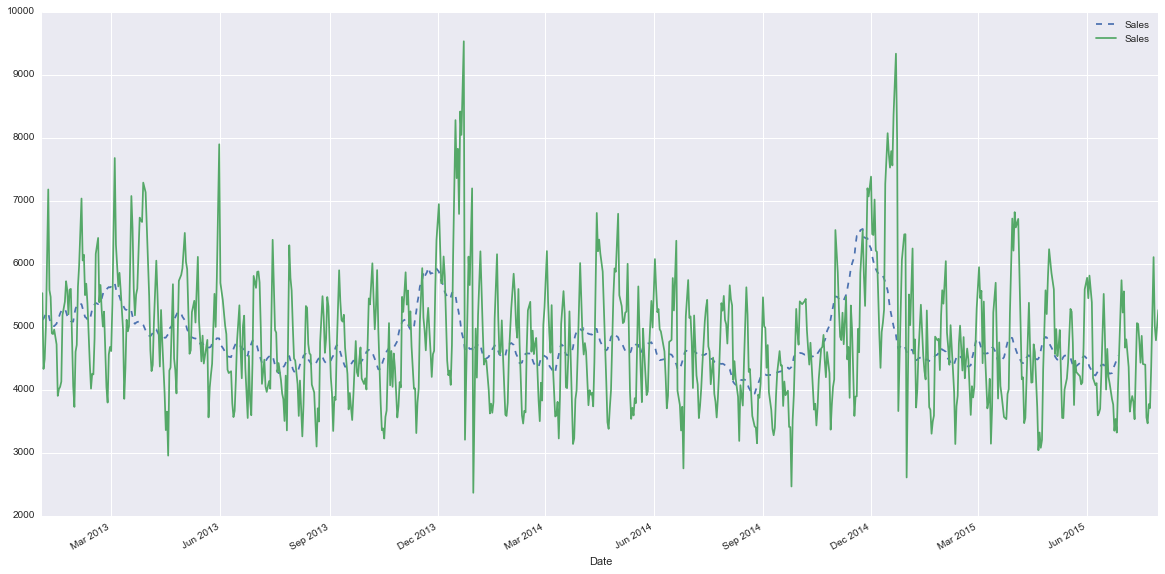

In [10]:
# fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True,figsize=(12, 7))
# pd.rolling_mean(store1sales,30).plot(ax=axes[0])
# store1sales.plot(y='Sales',ax=axes[1])

ax1 = store1sales.rolling(window=30).mean().plot(figsize=(20,10),style='--')
store1sales.plot(y='Sales',ax=ax1)


C:\Users\Chen Jenn Haur\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


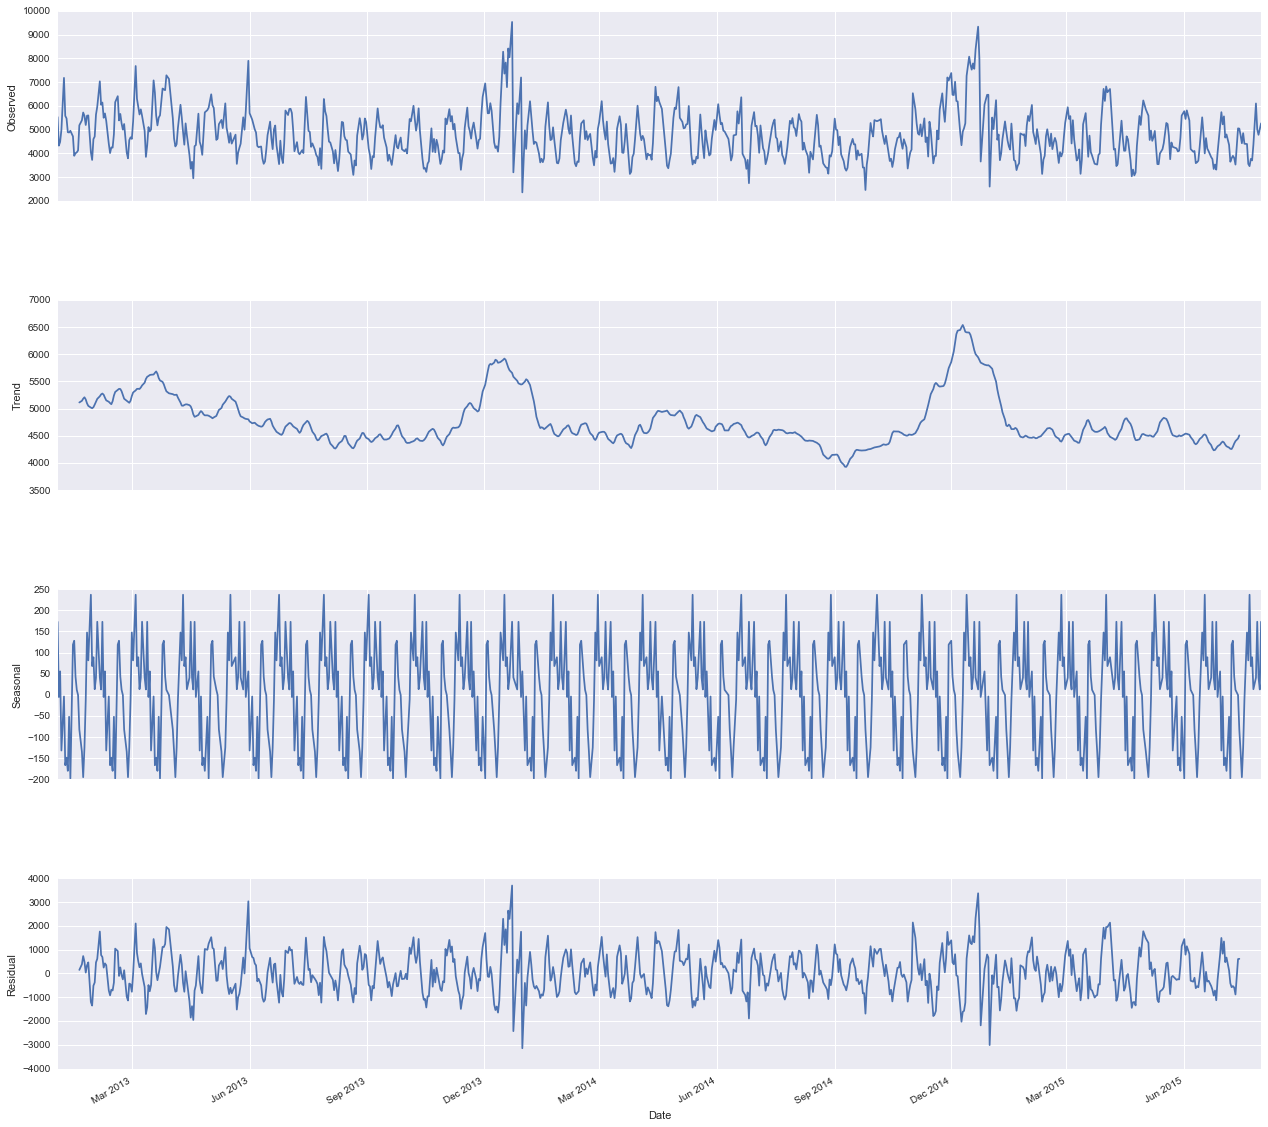

In [15]:
decomposition = seasonal_decompose(store1sales,freq=30)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 20)

In [19]:
decomposition.resid.head(5)
decomposition.trend.head(5)
decomposition.seasonal[:'2015-07-30']

,Sales
Date,
2015-07-31,172.739105


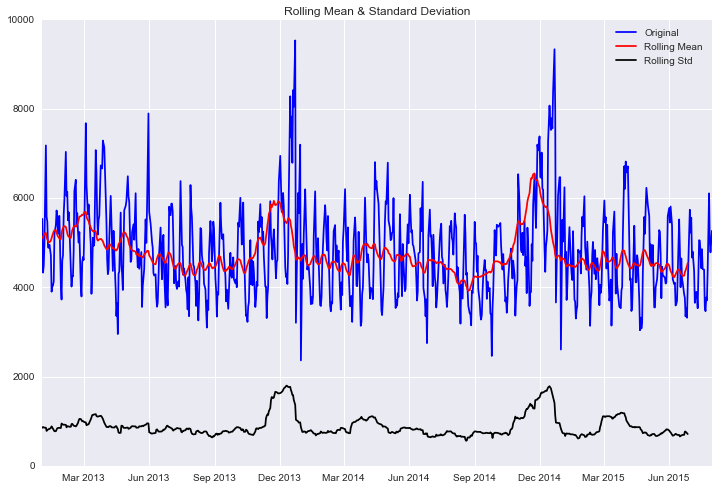

Results of Dickey-Fuller Test:
If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.


(-5.4127861045726231,
 3.1839264972729327e-06,
 13,
 767,
 {'1%': -3.4389045244994096,
  '10%': -2.5687805115003002,
  '5%': -2.8653156040031176},
 12091.691946988385)

In [5]:
def test_stationary(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    #Null Hypothesis - whether unit root is present in time series
    #Alternate Hypothesis - Stationary
    print('Results of Dickey-Fuller Test:')
    print('If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    display(dftest)

test_stationary(store1sales)

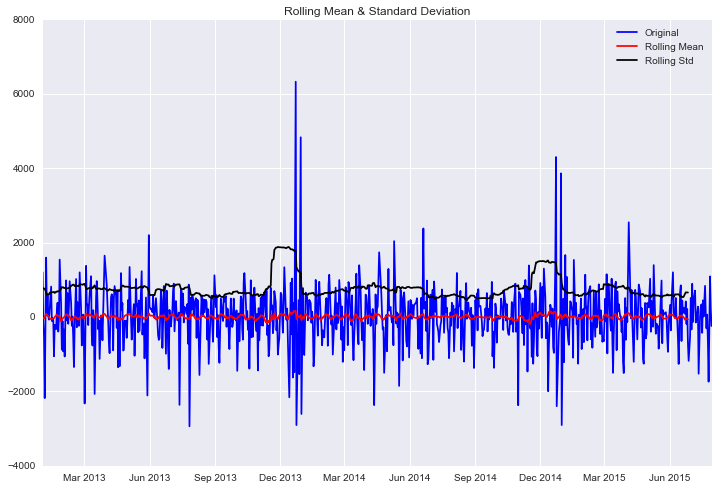

Results of Dickey-Fuller Test:
If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.


(-10.475259038926474,
 1.2538577737481344e-18,
 21,
 758,
 {'1%': -3.4390064424378761,
  '10%': -2.5688044403756587,
  '5%': -2.8653605216881308},
 12091.114913659881)

In [127]:
first_difference = store1sales - store1sales.shift(1)
test_stationary(first_difference.dropna())

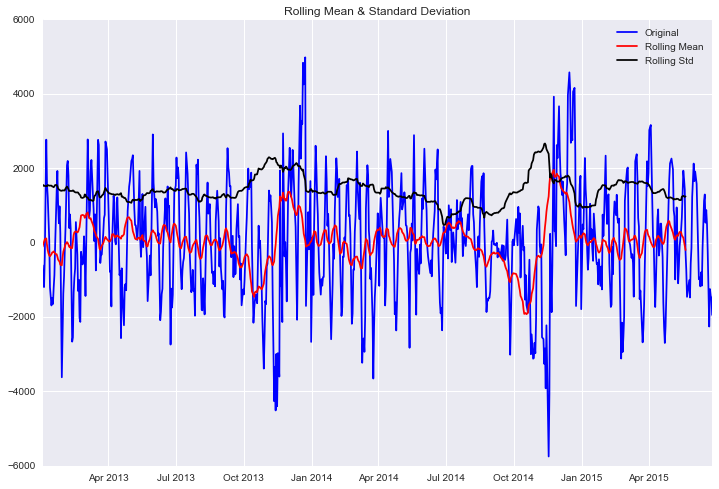

Results of Dickey-Fuller Test:
If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.


(-5.8557954116166737,
 3.5026739996284767e-07,
 13,
 737,
 {'1%': -3.4392539652094154,
  '10%': -2.5688625527782327,
  '5%': -2.8654696046504098},
 12150.577491782726)

In [18]:
seasonal_difference = store1sales - store1sales.shift(30)
test_stationary(seasonal_difference.dropna())

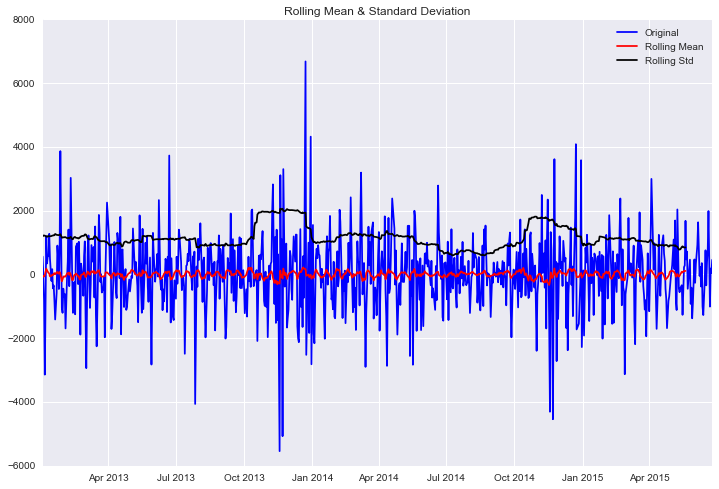

Results of Dickey-Fuller Test:
If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.


(-10.166660977063712,
 7.2688489951642735e-18,
 20,
 729,
 {'1%': -3.4393520240470554,
  '10%': -2.5688855736949163,
  '5%': -2.8655128165959236},
 12152.960810166885)

In [129]:
seasonal_first_difference = first_difference - first_difference.shift(30)
test_stationary(seasonal_first_difference.dropna())

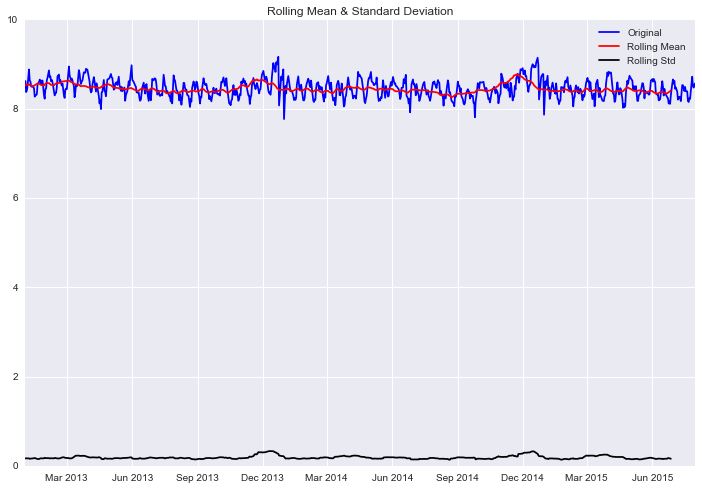

Results of Dickey-Fuller Test:
If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.


(-3.7550501429830017,
 0.0034021849398914502,
 21,
 759,
 {'1%': -3.4389949984547465,
  '10%': -2.5688017535207721,
  '5%': -2.8653554781248181},
 -800.53903249159521)

In [36]:
log_sales = store1sales.apply(lambda x: np.log(x))  
test_stationary(log_sales)

In [21]:
a = dfm[(dfm['Set']==1)&(dfm['Store']==1)&(dfm['Sales']>0)].groupby(['Store','Set','DateYear'])
a.count()

Customers  Date  DayOfWeek   Id  Open  Promo  Sales  \
Store Set DateYear                                                        
1     1   2013            303   303        303  303   303    303    303   
          2014            303   303        303  303   303    303    303   
          2015            175   175        175  175   175    175    175   

                    SchoolHoliday  StateHoliday  DateDay    ...      \
Store Set DateYear                                          ...       
1     1   2013                303           303      303    ...       
          2014                303           303      303    ...       
          2015                175           175      175    ...       

                    CompetitionOpenInt  Promo2SinceFloat  PromoInterval0  \
Store Set DateYear                                                         
1     1   2013                     303               303             303   
          2014                     303               303             303   
          2015                     175               175             175   

                    PromoInterval1  PromoInterval2  PromoInterval3  \
Store Set DateYear                                                   
1     1   2013                 303             303             303   
          2014                 303             303             303   
          2015                 175             175             175   

                    Sales_Mean  Sales_Median  Sales_HMean  Sales_Std  
Store Set DateYear                                                    
1     1   2013             303           303          303        303  
          2014             303           303          303        303  
          2015             175           175          175        175  

[3 rows x 31 columns]

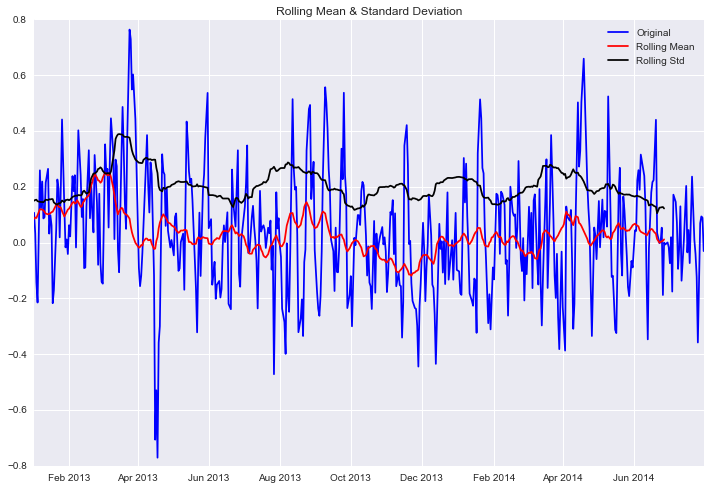

Results of Dickey-Fuller Test:
If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.


(-3.8374752199869797,
 0.0025463442127868635,
 11,
 466,
 {'1%': -3.4444609168389615,
  '10%': -2.5700842229549266,
  '5%': -2.8677622536920317},
 -341.01918617415731)

In [23]:
log_season_difference = log_sales - log_sales.shift(303)  
test_stationary(log_first_difference.dropna(inplace=False))

### PACF

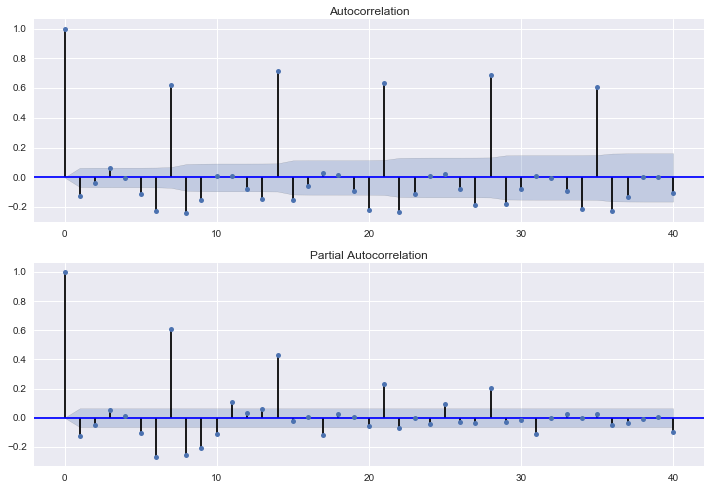

In [37]:
ts_data = storesales
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_data.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_data.iloc[13:], lags=40, ax=ax2)

In [44]:
storesales = dfm[(dfm['Store']==1)&(dfm['Set']==1)][['Date','Sales']]
storesales = storesales.set_index('Date')
storesales = storesales.sort_index(ascending=True)
storesales.to_csv('store1.csv')
storesales.index.min
storesales

,Sales
Date,
2013-01-01,0.0
2013-01-02,5530.0
2013-01-03,4327.0
2013-01-04,4486.0
2013-01-05,4997.0
2013-01-06,0.0
2013-01-07,7176.0
2013-01-08,5580.0
2013-01-09,5471.0


In [ ]:
# http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

model = ARIMA(log_sales, order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
# https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb
# http://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
# http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
# https://www.otexts.org/fpp/8/7

# mod = sm.tsa.statespace.SARIMAX(store1sales, trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
# results = mod.fit()
# print results.summary()

# df['forecast'] = results.predict(start = 102, end= 114, dynamic= True)  
# df[['riders', 'forecast']].plot(figsize=(12, 8))

In [71]:
dfm = dfm.set_index('Store',append=True,drop=False)
dfm = dfm.reorder_levels([1,0])
dfm = dfm.sort_index()



In [4]:
store_date_sales_month = dfm.groupby(['Store']).resample('M').sum()['Sales']
store_date_sales_month_lag1 = store_date_sales_month.unstack().T.shift(-1,freq='M').T.stack()
print(store_date_sales_month.loc[[1],:][0:10])
print(store_date_sales_month_lag1.loc[[1],:][0:10])

slag = pd.DataFrame(store_date_sales_month)
# Append 1 Month Lag
slag['Sales1Lag'] = store_date_sales_month.unstack().T.shift(-1,freq='M').T.stack()
# slag.loc[[1115],:]['Sales1Lag']

dfm['SalesM'] = slag['Sales']
dfm['SalesM'] = dfm['SalesM'].bfill()
# dfm.iloc[([1,2])]

Store            
1      2013-01-31    128431.0
       2013-02-28    125271.0
       2013-03-31    145169.0
       2013-04-30    118009.0
       2013-05-31    118225.0
       2013-06-30    113411.0
       2013-07-31    128032.0
       2013-08-31    118320.0
       2013-09-30    108867.0
       2013-10-31    114641.0
Name: Sales, dtype: float32
Store            
1      2012-12-31    128431.0
       2013-01-31    125271.0
       2013-02-28    145169.0
       2013-03-31    118009.0
       2013-04-30    118225.0
       2013-05-31    113411.0
       2013-06-30    128032.0
       2013-07-31    118320.0
       2013-08-31    108867.0
       2013-09-30    114641.0
dtype: float32


### XGB Boosting
Setup the parameters
Export to be run on R

In [59]:
sd_type = pd.get_dummies(dfxgb['StoreType'],prefix="stype")
sd_assort = pd.get_dummies(dfxgb['Assortment'],prefix='assort')
display(sd_assort.head(5))
display(sd_type.head(5))
dfxgb = pd.concat([dfxgb,sd_type,sd_assort],axis=1)
dfxgb = dfxgb.drop(['Assortment'],axis=1).drop(['StoreType'],axis=1)
dfxgb['stype_0'] = dfxgb['stype_0'].astype(np.int8)
dfxgb['stype_1'] = dfxgb['stype_1'].astype(np.int8)
dfxgb['stype_2'] = dfxgb['stype_2'].astype(np.int8)
dfxgb['stype_3'] = dfxgb['stype_3'].astype(np.int8)
dfxgb['assort_0'] = dfxgb['assort_0'].astype(np.int8)
dfxgb['assort_1'] = dfxgb['assort_1'].astype(np.int8)
dfxgb['assort_2'] = dfxgb['assort_2'].astype(np.int8)

In [60]:
# s_test = dfxgb[(dfxgb['Store']==1)&(dfxgb['Set']==1)].copy()

In [ ]:
# s_test['CompetitionOpenSinceYear']

In [64]:
display(dfxgb.iloc[1:4,1:14])
display(dfxgb.iloc[1:4,14:21])
display(dfxgb.iloc[1:4,21:28])
display(dfxgb.iloc[1:4,28:40])
display(dfxgb.iloc[1:4,40:45])

,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,Store,DateDay,DateWeek,DateMonth
1,2015-07-31,5,0,1,1,6064.0,1,1,0,2,31,31,7
2,2015-07-31,5,0,1,1,8314.0,1,1,0,3,31,31,7
3,2015-07-31,5,0,1,1,13995.0,1,1,0,4,31,31,7


,DateYear,DateDayOfYear,DateInt,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek
1,2015,212,1438272000,570,11,2007,13
2,2015,212,1438272000,14130,12,2006,14
3,2015,212,1438272000,620,9,2009,0


,Promo2SinceYear,CompetitionOpenInt,Promo2SinceFloat,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
1,2010,1193846400,1269792000,1,4,7,10
2,2011,1164902400,1301846400,1,4,7,10
3,0,1251734400,0,0,0,0,0


,Sales_Mean,Sales_Median,Sales_HMean,Sales_Std,stype_0,stype_1,stype_2,stype_3,assort_0,assort_1,assort_2
1,4122.991699,4395.5,4431.563643,2363.628672,1,0,0,0,1,0,0
2,5462.890137,5713.5,6282.238539,3446.161778,1,0,0,0,1,0,0
3,8021.769531,9062.0,9288.399486,4012.592803,0,0,1,0,0,0,1


""
1
2
3
